1. Setup and Dataset Preparation


1.1. Install and Import Library

This stage involves setting up and preparing the necessary libraries for deep learning, image processing, visualization, and model evaluation, ensuring an efficient workflow for CNN-based image classification and transfer learning.

In [1]:
!pip install kaggle tensorflow opencv-python matplotlib seaborn scikit-learn keras-tuner
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00


1.2. Download Dataset from Kaggle

This process involves downloading a dataset from Kaggle in Google Colab by setting up API authentication. First, the code imports the necessary module from google.colab to upload the kaggle.json file, which contains the user's Kaggle API credentials. Next, it creates a hidden .kaggle directory, moves the kaggle.json file into it, and modifies its permissions to ensure security. After setting up authentication, the code executes the command kaggle datasets download -d jessicali9530/celeba-dataset to download the CelebA dataset. This process enables users to efficiently access and work with Kaggle datasets within the Colab environment for deep learning and machine learning tasks.

In [2]:
from google.colab import files
files.upload()  # Select the kaggle.json file that has been downloaded

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:07<00:00, 245MB/s]
100% 1.33G/1.33G [00:07<00:00, 190MB/s]


1.3. Dataset Extraction

This process starts by extracting the celeba-dataset.zip file into a folder called CelebA using the !unzip command, which is commonly used in Google Colab and Unix-based systems. Once the extraction is complete, two important file paths are set up. The IMG_PATH points to the folder where the aligned CelebA images are stored, while FEATURE_PATH links to the list_attr_celeba.csv file, which contains attribute labels for each image. These paths make it easy to load and process both the images and their attributes, allowing them to be used effectively in deep learning models for training and analysis.

In [3]:
!unzip celeba-dataset.zip -d CelebA
IMG_PATH = '/content/CelebA/img_align_celeba/img_align_celeba'
FEATURE_PATH = '/content/CelebA/list_attr_celeba.csv'


Streaming output truncated to the last 5000 lines.
  inflating: CelebA/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197617.jpg  
  inflating

2. Data Preprocessing

2.1. Load dan Cleaning Dataset

The purpose of this step is to prepare and clean the dataset for gender classification using deep learning or machine learning models. By selecting only the relevant columns (image_id and Male), the dataset becomes more focused and efficient for processing. The removal of missing values and duplicates ensures data integrity and prevents inconsistencies that could affect model performance. Mapping the Male column values to readable gender labels (Male and Female) enhances interpretability, making the dataset more user-friendly. Dropping the original Male column simplifies the structure, keeping only essential information. Overall, this preprocessing step ensures that the data is clean, well-structured, and ready for training and analysis.

In [4]:
# Read the CSV data
df = pd.read_csv(FEATURE_PATH, usecols=['image_id', 'Male'])

# Display the number of data before handling missing values and duplicates
print("Initial number of data:", len(df))
print("Number of missing values before removal:\n", df.isnull().sum())
print("Number of duplicate data before removal:", df.duplicated().sum())

# Convert the 'Male' column values to categorical
df.loc[df['Male'] == -1, 'Male'] = "Female"
df.loc[df['Male'] == 1, 'Male'] = "Male"

# Rename the columns
df.columns = ["image_id", "Gender"]

# Remove rows with missing values
df = df.dropna()

# Display the results after removing missing values
print("\nNumber of data after removing missing values:", len(df))
print("Number of missing values after removal:\n", df.isnull().sum())

# Remove duplicate data
df = df.drop_duplicates()

# Display the results after removing duplicate data
print("\nNumber of data after removing duplicate data:", len(df))
print("Number of duplicate data after removal:", df.duplicated().sum())

# Display the top 5 data to verify the results
print("\nSample data after cleaning:")
print(df.head())


Initial number of data: 202599
Number of missing values before removal:
 image_id    0
Male        0
dtype: int64
Number of duplicate data before removal: 0


<ipython-input-4-6dd509f07841>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Female' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Male'] == -1, 'Male'] = "Female"



Number of data after removing missing values: 202599
Number of missing values after removal:
 image_id    0
Gender      0
dtype: int64

Number of data after removing duplicate data: 202599
Number of duplicate data after removal: 0

Sample data after cleaning:
     image_id  Gender
0  000001.jpg  Female
1  000002.jpg  Female
2  000003.jpg    Male
3  000004.jpg  Female
4  000005.jpg  Female


2.2. Load and Preprocessing Image

In [ ]:
def load_and_process_image(image_id, img_size=(128, 128)):
    """Loads and preprocesses an image for model training.

    Args:
        image_id (str): The ID or filename of the image.
        img_size (tuple): The desired size for resizing the image.

    Returns:
        numpy.ndarray: The preprocessed image as a NumPy array.
    """
    img_path = os.path.join(IMG_PATH, image_id)
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0  # Normalization
    return img

X = np.array([load_and_process_image(img_id) for img_id in df['image_id']])


2.3. Sampling Data and Label Encoding

This step prepares a 5,000-sample subset of the dataset by randomly selecting entries while maintaining a consistent index. The corresponding images are then loaded and processed into a NumPy array using load_and_process_image(img_id), ensuring proper formatting for deep learning models. The gender labels are encoded into binary values (1 for Male, 0 for Female) for classification. Finally, df.head() displays the first few rows of the dataset to verify the preprocessing, ensuring the data is clean and ready for model training.

In [ ]:
df = df.sample(n=5000, random_state=42).reset_index(drop=True)
X = np.array([load_and_process_image(img_id) for img_id in df['image_id']]) # load_and_process_image called here
y = np.where(df['Gender'] == 'Male', 1, 0)  # Label Encoding (1: Male, 0: Female)
df.head()

,image_id,Gender
0,143814.jpg,Female
1,169897.jpg,Female
2,176441.jpg,Male
3,011472.jpg,Male
4,130958.jpg,Female


The data shows a small sample of the dataset containing two columns: image_id and Gender.

image_id represents the unique identifier for each image, which in this case, are filenames (e.g., "143814.jpg", "176441.jpg").
Gender indicates the gender label associated with each image, where "Female" and "Male" are the values representing the gender of the person in the image.
This dataset pairs each image with its corresponding gender label, which can be used for tasks such as image classification or gender prediction in machine learning models.

2.4 Visualization of Data Distribution

This step visualizes sample images and analyzes gender distribution in the dataset. The first loop selects six images, loads them using OpenCV (cv2.imread), converts them from BGR to RGB (cv2.cvtColor), and displays them using Matplotlib. The second part checks the distribution of gender labels by counting occurrences of "Male" and "Female" in the dataset and plotting a bar chart. This helps in understanding data balance before training a deep learning model.

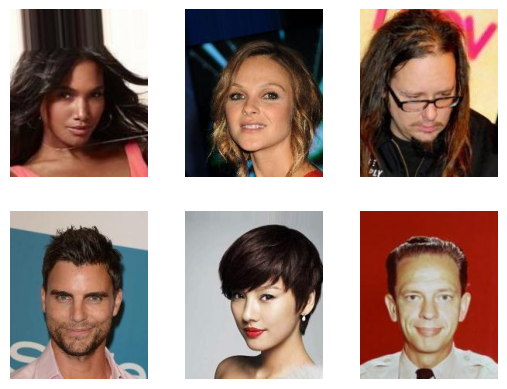

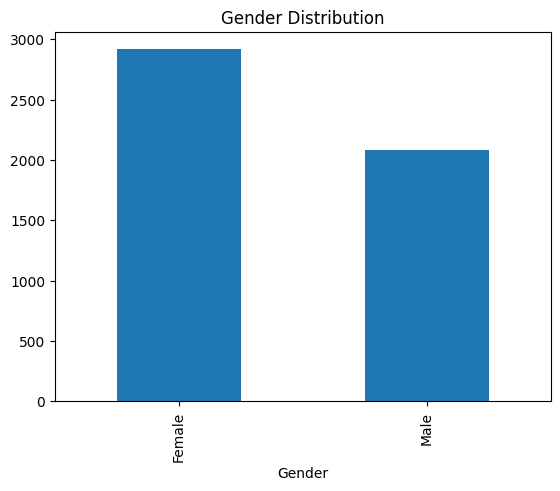

In [ ]:
# Visualization of several images
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Check Gender Distribution
category_count = df["Gender"].value_counts()
category_count.plot.bar()
plt.title("Gender Distribution")
plt.show()


The load_and_process_image function loads an image from a given file path using its image_id and resizes it to the specified img_size (default 128x128). It then normalizes the image by converting the pixel values to a float32 type and scaling them to a range between 0 and 1. Finally, the function returns the preprocessed image as a NumPy array, and this is applied to a DataFrame of image IDs to create an array of processed images (X).

2.5. Train-Test-Validation Split

This process splits the dataset into training, validation, and test sets. The first split divides the dataset into 70% for training and 30% for further splitting. The second split divides the 30% set equally into 50% for validation and 50% for testing. The stratify parameter ensures that the gender distribution is consistent across all sets, helping prevent class imbalance. The result is a balanced, properly partitioned dataset for model training, validation, and testing.

The 70-30 split is considered appropriate for the CelebA dataset, which contains over 200,000 images, because even though only 5000 samples are selected, the data used for training remains diverse enough to capture key patterns. By using 70% of the data for training, the model can learn effectively from various image variations, such as gender, facial expressions, and other attributes, while the remaining 30% provides sufficient data for validation and testing. Even with fewer samples, these are still representative of the overall data distribution, allowing for reliable evaluation of the model's performance. This split strikes a good balance between maximizing the use of data for training and maintaining evaluation quality, ensuring that testing and validation provide a solid understanding of the model's generalization in a broader context.

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Gender'], random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Gender'], random_state=42)


2.6. Data Augmentation

This code defines the data preprocessing and augmentation pipeline for training, validation, and testing a deep learning model. The ImageDataGenerator is used to preprocess images by rescaling pixel values to a range of [0,1]. For the training set, additional augmentations such as rotation (up to 30 degrees), zooming (up to 20%), and horizontal flipping are applied to improve generalization. The flow_from_dataframe function loads image file paths and corresponding labels from dataframes, resizes images to 128x128 pixels, and generates batches of size 32. The validation and test datasets are only rescaled without augmentation to ensure consistent evaluation. The test generator is set with shuffle=False to maintain label order for accurate predictions and performance evaluation.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, directory=IMG_PATH,
    x_col='image_id', y_col='Gender',
    target_size=(128, 128),
    batch_size=32, class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=validation_df, directory=IMG_PATH,
    x_col='image_id', y_col='Gender',
    target_size=(128, 128),
    batch_size=32, class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df, directory=IMG_PATH,
    x_col='image_id', y_col='Gender',
    target_size=(128, 128),
    batch_size=32, class_mode='binary', shuffle=False
)

Found 3500 validated image filenames belonging to 2 classes.
Found 750 validated image filenames belonging to 2 classes.
Found 750 validated image filenames belonging to 2 classes.


The output indicates the results of loading the images for the training, validation, and test sets using the flow_from_dataframe method. The training dataset consists of 3,500 images, and each image is assigned to one of two classes, "Male" or "Female." The validation dataset contains 750 images, also divided into the two classes, while the test dataset also has 750 images with the same two classes. In summary, the dataset has been split into three parts: 3,500 images for training, 750 images for validation, and 750 images for testing, all balanced between the two classes, making them ready for use in training and evaluating the deep learning model.

3. Model Development

3.1. CNN Architecture with Transfer Learning (ResNet)

The build_model function creates a deep learning model using a pre-trained InceptionV3 without its top layers and with ImageNet weights, setting the base model's layers to non-trainable. It then adds a Flatten layer, followed by a Dense layer with tunable units, a Dropout layer, and a final Dense layer with a sigmoid activation for binary classification. Hyperparameters such as the number of units, dropout rate, and learning rate are optimized using Keras Tuner, and the model is compiled with the Adam optimizer and binary cross-entropy loss.

In [ ]:
def build_model(hp):
    from tensorflow.keras.optimizers import Adam

   # Load the ResNet50 model without the top layers and with ImageNet weights
    base_inception_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_inception_model.trainable = False  # Disable training for the base model

    model = Sequential([
        base_inception_model,
        Flatten(),
        Dense(hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


3.2. Hyperparameter Tuning with Bayesian Optimization

This process involves hyperparameter tuning using Keras Tuner's Bayesian Optimization to optimize the model architecture. The BayesianOptimization tuner is initialized with the build_model function, aiming to maximize validation accuracy (val_accuracy). The search is configured with a maximum of 3 trials, where each trial tests a different set of hyperparameters, and each trial runs once (executions_per_trial=1). The results are stored in the 'my_dir' directory under the project name 'gender_classification'. The tuner.search function then trains multiple model variations on the train_generator dataset for 1 epoch, validating against validation_generator to find the best hyperparameter combination.

In [ ]:
!pip install keras-tuner
from kerastuner.tuners import BayesianOptimization # Import BayesianOptimization

tuner = BayesianOptimization(
    build_model, objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir', project_name='gender_classification'
)

tuner.search(train_generator, epochs=1, validation_data=validation_generator)

Trial 3 Complete [00h 03m 31s]
val_accuracy: 0.7599999904632568

Best val_accuracy So Far: 0.8346666693687439
Total elapsed time: 00h 11m 31s


Trial 3 was completed in 3 minutes and 31 seconds, achieving a validation accuracy of 0.76. So far, the best validation accuracy achieved across all trials is 0.83. The total elapsed time for all trials conducted up to this point is 11 minutes and 31 seconds.

3.3. Model Training with Best Hyperparameter

This code defines and utilizes three callbacks during the training of a model to enhance its performance and prevent overfitting. The ReduceLROnPlateau callback adjusts the learning rate by reducing it by half if the validation loss (val_loss) doesn't improve after 2 epochs, ensuring the model can continue learning effectively. The EarlyStopping callback halts the training if the validation loss doesn't improve for 2 consecutive epochs, while restoring the best weights from earlier in training to avoid overfitting. The ModelCheckpoint callback saves the model with the best validation loss to an HDF5 file (best_model.h5). After tuning, the best hyperparameters are retrieved and used to build the model, which is then trained using these callbacks. The model is trained for 10 epochs with batch processing and validation, ensuring the training process benefits from adaptive learning rate adjustments, early stopping, and saving the best model.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callback to reduce the learning rate when val_loss stagnates
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)

# Callback to stop training if val_loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Callback to save the best model based on val_loss, with the .h5 format
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode="min")

# Retrieve the best hyperparameters from tuning
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the model with ReduceLROnPlateau and ModelCheckpoint
history = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10, # 'epochs' is already defined here
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7188 - loss: 10.3404

110/110 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7193 - loss: 10.2791 - val_accuracy: 0.8347 - val_loss: 0.4018 - learning_rate: 0.0100
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8184 - loss: 0.4103

110/110 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8184 - loss: 0.4103 - val_accuracy: 0.8387 - val_loss: 0.3558 - learning_rate: 0.0100
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.8367 - loss: 0.3917 - val_accuracy: 0.8360 - val_loss: 0.3751 - learning_rate: 0.0100
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8300 - loss: 0.3871 - val_accuracy: 0.8493 - val_loss: 0.3761 - learning_rate: 0.0100


During the training process, the model showed significant improvement from epoch 1 to epoch 2, with the loss decreasing from 10.2791 to 0.4103 and validation accuracy increasing from 0.8347 to 0.8387. However, in epochs 3 and 4, the validation loss slightly fluctuated, increasing from 0.3558 to 0.3751 and then to 0.3761, despite a stable learning rate of 0.0100.

The training stopped at epoch 4 due to the EarlyStopping callback, which monitors the validation loss (val_loss) and halts training when there’s no improvement for 2 consecutive epochs (patience=2). After epoch 2, the val_loss increased from 0.3558 to 0.3751 in epoch 3, and slightly increased again to 0.3761 in epoch 4. Since the model failed to improve its val_loss for two consecutive epochs, EarlyStopping was triggered to prevent overfitting and save computational resources.

4. Model Evaluation

4.1. Model Performance Evaluation

This code evaluates the trained model on the validation set using the evaluate() method. It calculates the validation loss and accuracy by comparing the model's predictions against the actual labels in the validation dataset. The results are printed, showing the validation loss and accuracy values, which help assess the model's performance on unseen data.

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8282 - loss: 0.3757
Validation Loss: 0.3558
Validation Accuracy: 0.8387


The model achieved a training accuracy of 82.82% with a loss of 0.3757, indicating good performance on the training data. On the validation set, it reached an accuracy of 83.87% with a slightly lower loss of 0.3558, suggesting that the model generalizes well to unseen data. The close values between training and validation metrics indicate minimal overfitting.

4.2. Confusion Matrix

24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step


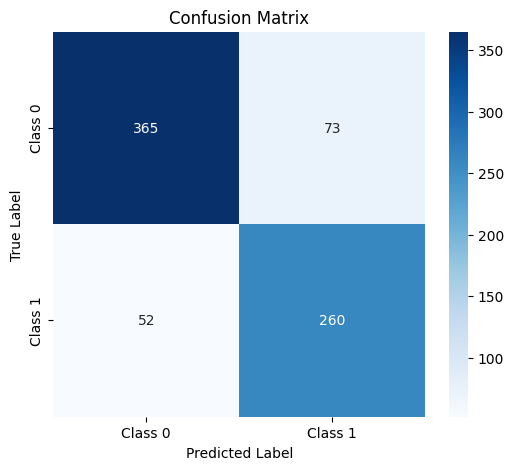

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       438
           1       0.78      0.83      0.81       312

    accuracy                           0.83       750
   macro avg       0.83      0.83      0.83       750
weighted avg       0.84      0.83      0.83       750



In [ ]:
# Get predictions from the model
y_true = test_generator.classes  # True labels
y_pred_prob = best_model.predict(test_generator)  # Output probabilities
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Convert to binary labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))


The confusion matrix shows that the model correctly predicted 365 instances of Class 0 and 260 instances of Class 1, while misclassifying 73 instances of Class 0 as Class 1 and 52 instances of Class 1 as Class 0. This indicates a relatively balanced performance across both classes. The classification report supports this observation, with an overall accuracy of 83%. Class 0 has a higher precision (0.88) compared to Class 1 (0.78), suggesting that when the model predicts Class 0, it is more likely to be correct. However, both classes share the same recall of 0.83, meaning the model is equally effective at identifying actual instances of both classes. The F1-scores of 0.85 for Class 0 and 0.81 for Class 1 indicate a slight imbalance, favoring Class 0. The macro and weighted averages suggest stable overall model performance, with no extreme biases.